**Oreum Industries Internal Project, 2024Q3**

---

# 202_AFT_GompertzAlt.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.


**In this Notebook:**

+ We extend our basic understanding with worked examples of parametric models in the AFT
  architecture family, using our real-world observational censored dataset.
+ Specifically: **A Parametric Regression aka Accelerated Failure Time Model: Gompertz Alternative Parameterization**


## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `GompertzAltRegression`](#2.-Custom-Bayesian-Model-`GompertzAltRegression`)

---

---

# Setup

## Imports

In [1]:
import sys
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here
from scipy import stats

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))


from engine import logger
from model import aft, exponential, utils

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('202_AFT_GompertzAlt', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 We reparameterise the Gompertz likelihood distribution to avoid correlations

This alternative modal parameterisation is suggested by 
[Missov et al 2015](https://www.demographic-research.org/articles/volume/32/36/)
and further exampled by 
[Monika Alexander](https://www.monicaalexander.com/posts/2018-02-15-gompertz/)
with more helpful background on Location-Scale models w.r.t. Gompertz by 
[Popul, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6797696/). NOTE We 
continue to use the cleaner parameterisation by
[Random Services](https://www.randomservices.org/random/special/Gompertz.html) 
(see Section 21)

The core motivation is twofold:

1. The conventional params `eta` and `gamma` are highly (and negatively) correlated:
   see our example in `201_AFT_Gompertz.ipynb` $\S2.7.1$
2. The conventional param `eta` isn't particuarly intuitive.


Instead we will use the "modal age of old-age death" aka the **mode of the event density function**, $M$:

$$
\begin{aligned}
M &= - \frac{1}{\gamma} \log \eta \\
\text{... so:} \\
\eta &= \exp (-\gamma M) \\
\end{aligned}
$$

## 1.2 Gompertz Alternative Parameterization



Showing the main functional relationships in uncensored form (left) and (where relevant $\longrightarrow$ on the right) the censored version,
also showing simplified forms where possible, since the notation has gotten wild

$$
\begin{aligned}
\text{... substituting: } \eta &= \exp (-\gamma M) \\
\\
\lambda(t) &= \exp (-\gamma M) \ \gamma \exp \left( \gamma t \right) \\
                 &= \gamma \exp \left( \gamma t - \gamma M \right)  \\
                 &= \gamma \exp \left( \gamma (t - M) \right) &\longrightarrow \left(\gamma \exp \left( \gamma (t - M) \right) \right)^{d_{i}} \\
\\
\Lambda(t) &= \exp (-\gamma M) \left( \exp \left( \gamma t \right) + 1 \right) \\
                 &= \exp \left( \gamma (t - M) \right) + \exp \left( -\gamma M \right) \\
\\
S(t) &= \exp \left( - \exp(-\gamma M) \left( \exp(\gamma t) - 1 \right) \right) \\
           &= \exp \left( \exp \left( -\gamma M \right) - \exp \left( \gamma (t - M) \right) \right) \\
\\
S^{-1}(u) &= \frac{1}{\gamma} \log \left(1 - \frac{\log(1 - u)}{\exp (-\gamma M)} \right) \\ 
\\
\hat{\pi}(t) 
        &\sim \gamma \exp \left( \gamma (t - M) \right) \cdot \exp \left( \exp \left( -\gamma M \right) - \exp \left( \gamma (t - M) \right) \right)
        &\longrightarrow \left( \gamma \exp \left( \gamma (t - M) \right) \right)^{d_{i}} \cdot \exp \left( \exp \left( -\gamma M \right) - \exp \left( \gamma (t - M) \right) \right) \\
        % &\sim \gamma \exp \left( \gamma (t - M) + \exp \left( -\gamma M \right) - \exp \left( \gamma (t - M) \right) \right) \\
        &\sim \text{Gompertz}(t\ |\ M, \gamma) \\
\text{... so:} \\
\log \mathcal{L}\ \hat{\pi}(t) 
        &\sim \log \gamma + \gamma (t - M) + \exp \left( -\gamma M \right) - \exp \left( \gamma (t - M) \right)
        &\longrightarrow \sum_{i} d_{i} \left( \log \gamma  + \gamma (t - M) \right) + \exp \left( -\gamma M \right) - \exp \left( \gamma (t - M) \right) \\
\end{aligned}
$$

where:
+ mode $M > 0$, scale $\gamma > 0$
+ $d_{i} \in {0, 1}$:


## 1.3 Building the linear submodel for regression

Regression considerations:
+ We should choose one parameter for the regression term $\beta\mathbf{x}$,
  or carefully manage the covariance between the two. 
+ Because $M$ affects the mode, we will set $M = \exp (\beta^{T}\mathbf{x})$

Prior considerations
+ So our hyperpriors with initial, reasonably uninformative values look like:

$$
\begin{aligned}
\sigma_{\beta} &\sim \text{InvGamma}(\alpha=2, \beta=2)   &\ \ \text{Shared variance for } \beta, \mathbb{E} \sim 2 \\
\beta &\sim \text{Normal}(\mu=2, \sigma=\sigma_{\beta})  &\ \ \text{Unpooled } \beta, \mathbb{E} \sim 2 \\
M &= \exp (\mathbf{\beta}^{T}\mathbf{x})         &\ \ \text{Regression prior for } M, \mathbb{E} \approx[7, 50]\\
\gamma &\sim \text{InvGamma}(\alpha=11, \beta=1)           &\ \ \text{Pooled } \gamma, \mathbb{E} \sim 0.1 \\
\end{aligned}
$$

+ Do randomly generated times $t$ look reasonable?

$$
\begin{aligned}
u &\sim \text{Uniform}(0, 1) \\
\hat{t} &\sim \hat{S}^{-1}(u) \\
        &\sim \frac{1}{\gamma} \log \left(1 - \frac{\log(1 - u)}{\exp (-\gamma M)} \right) \\
        &\sim \frac{1}{0.1} \log \left(1 - \frac{\log(1 - u)}{\exp (-0.1 * 55)} \right) \text{, when all at } \mathbb{E} \\
        &\approx \begin{cases}
            12 & \textrm{if } u = 0.01 \\
            70 & \textrm{if } u = 0.99 \\
        \end{cases}
\end{aligned}
$$

+ This is a narrow span of days `duration`, compared to our dataset, but in the right ballpark to start

## 1.4 Illustration of functions to aid intuition

What does $M$ do?

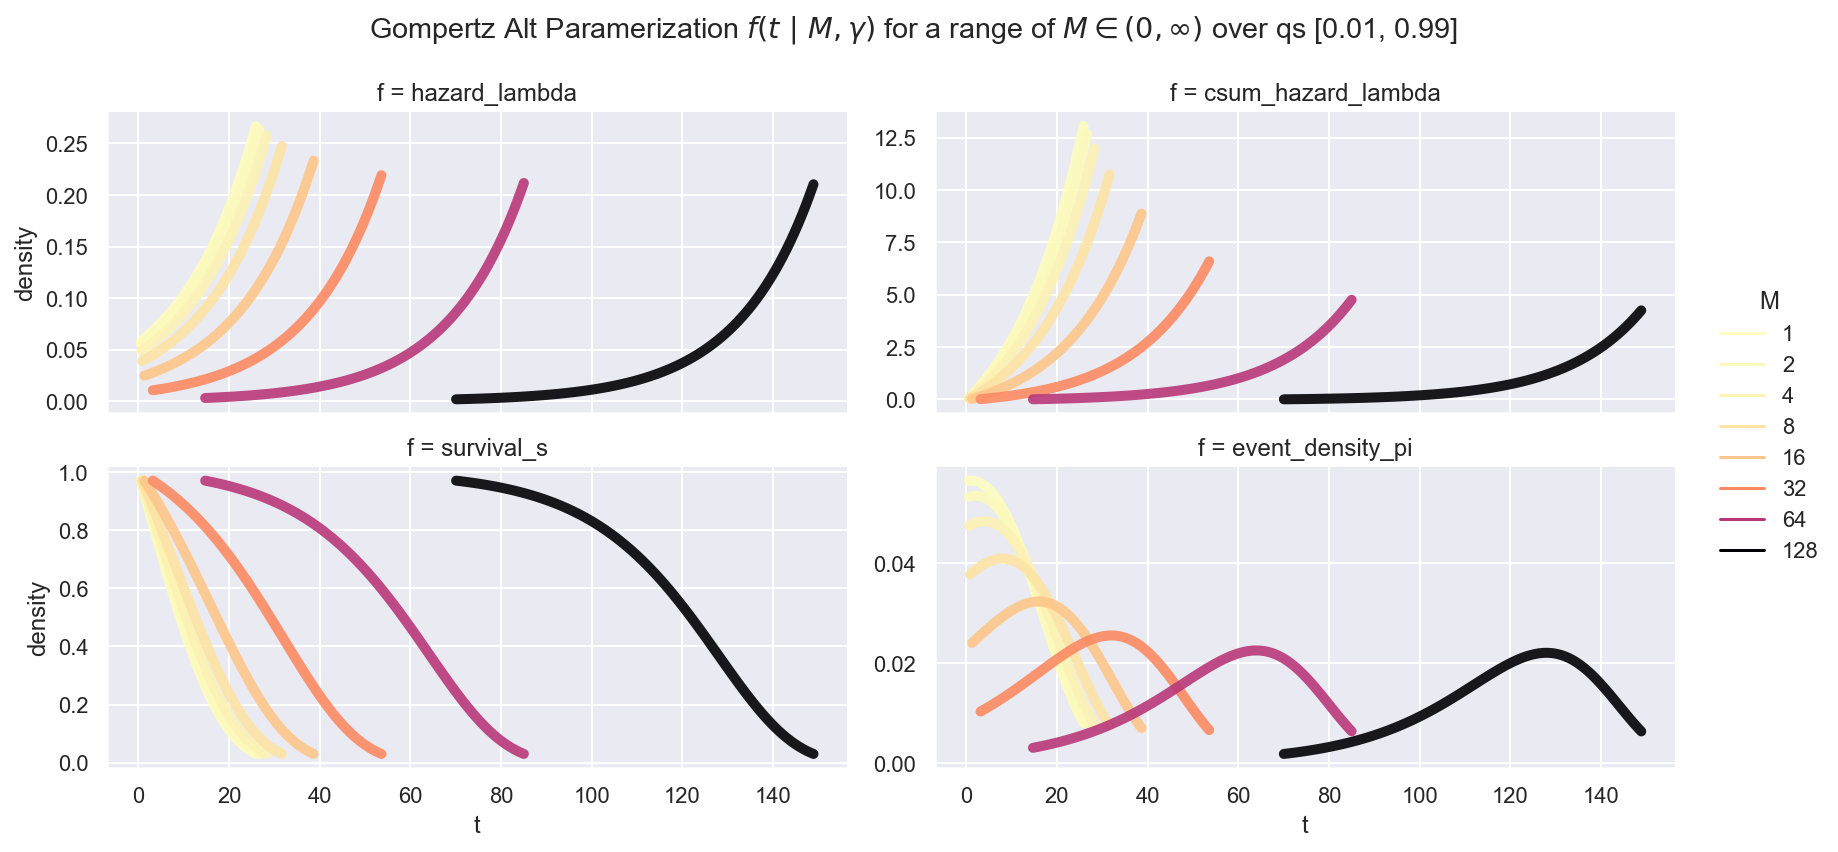

In [7]:
Ms = np.array([1, 2, 4, 8, 16, 32, 64, 128])
gamma = 0.06
get_e = lambda M: np.exp(-gamma * M)
dff = pd.concat([utils.get_fs(stats.gompertz(get_e(M), scale=1 / gamma), {'M': M}) for M in Ms])
_ = utils.plot_f(dff, f_nm='Gompertz Alt Paramerization $f(t\ |\ M, \gamma)$', p_nm='M')

**Observe:**

+ Move the mode $M$

#### What does $\gamma$ do?

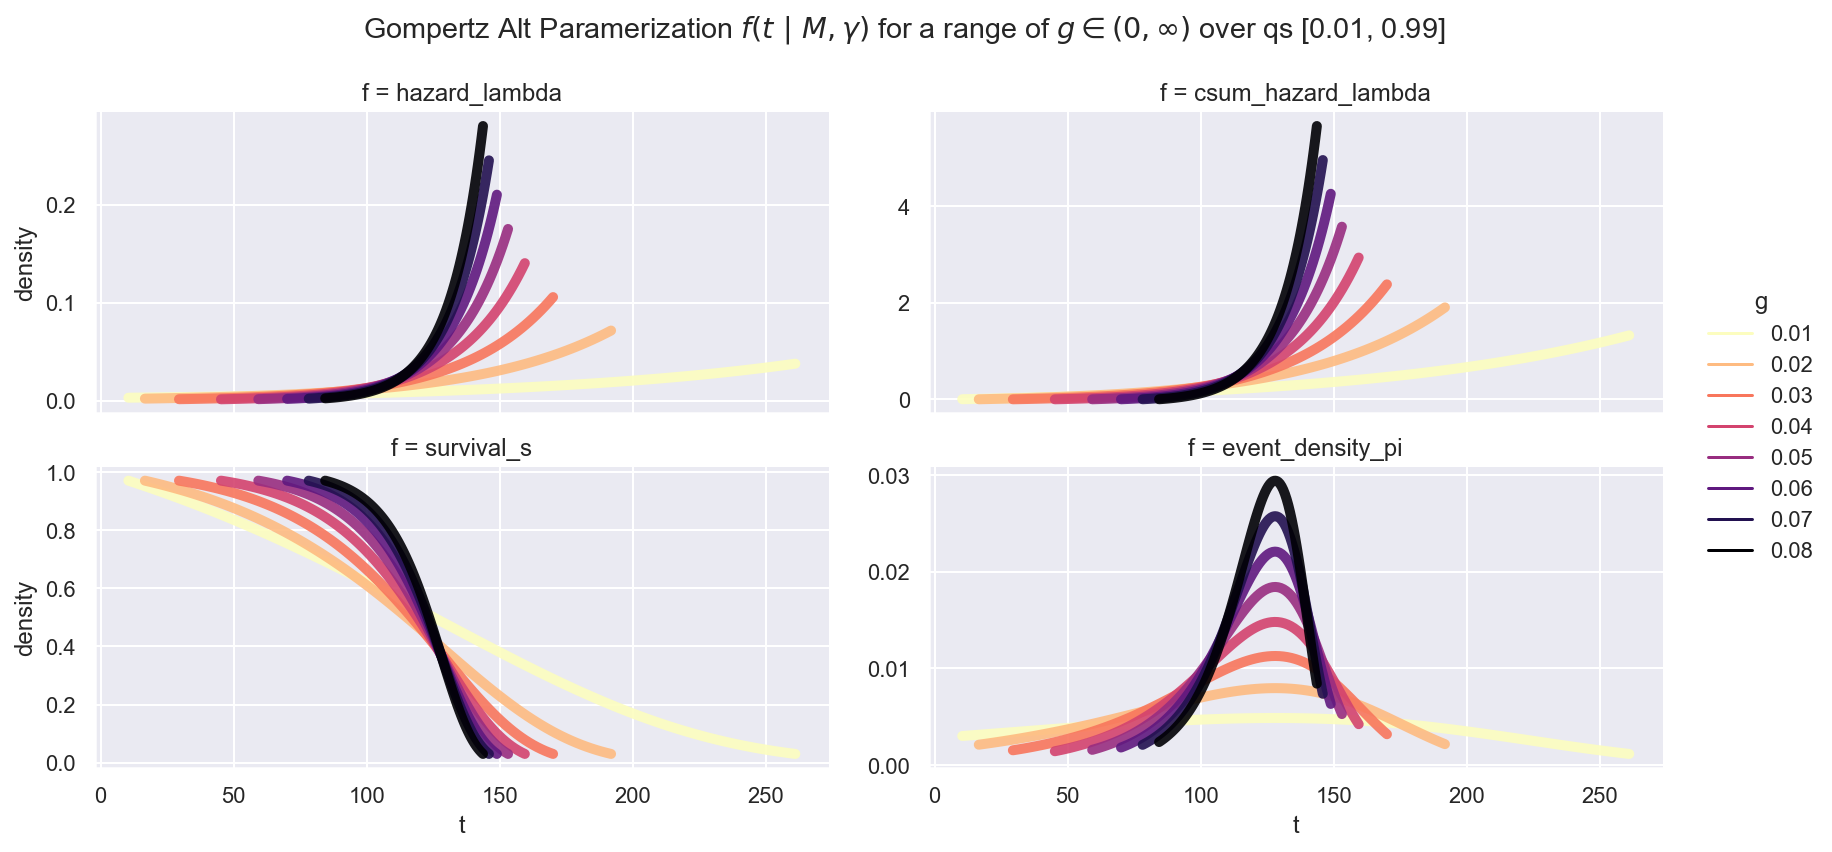

In [8]:
M = 128
gammas = np.arange(0.01, 0.09, 0.01)
get_e = lambda g: np.exp(-g * M)
dff = pd.concat([utils.get_fs(stats.gompertz(get_e(g), scale=1 / g), {'g': g}) for g in gammas])
_ = utils.plot_f(dff, f_nm='Gompertz Alt Paramerization $f(t\ |\ M, \gamma)$', p_nm='g')

**Observe:**

+ Sharpen the mode

---

---

# 2. Custom Bayesian Model `GompertzRegressionAlt`

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [9]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 2.1 Build Model Object

`GompertzRegressionAlt` model imported from `src.models.aft.py` where it is fully defined

In [10]:
mdl_ga = aft.GompertzRegressionAlt(obs=dfx, fts_en=dfx_creator.fts_en, factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_ga.build()
utils.display_rvs(mdl_ga)
mdl_ga.debug()

'RVs for gompertz_regression_alt, v0.1.0, dfx'

beta_s ~ InverseGamma(5, 1)

beta ~ Normal(2, beta_s)

gamma ~ InverseGamma(11, 1)

m ~ Deterministic(f(beta))

shat ~ Deterministic(f(gamma, beta))

point={'beta_s_log__': array(-1.38629436), 'beta': array([2., 2.]), 'gamma_log__': array(-2.30258508)}

No problems found
point={'beta_s_log__': array(-1.38629436), 'beta': array([2., 2.]), 'gamma_log__': array(-2.30258508)}

No problems found


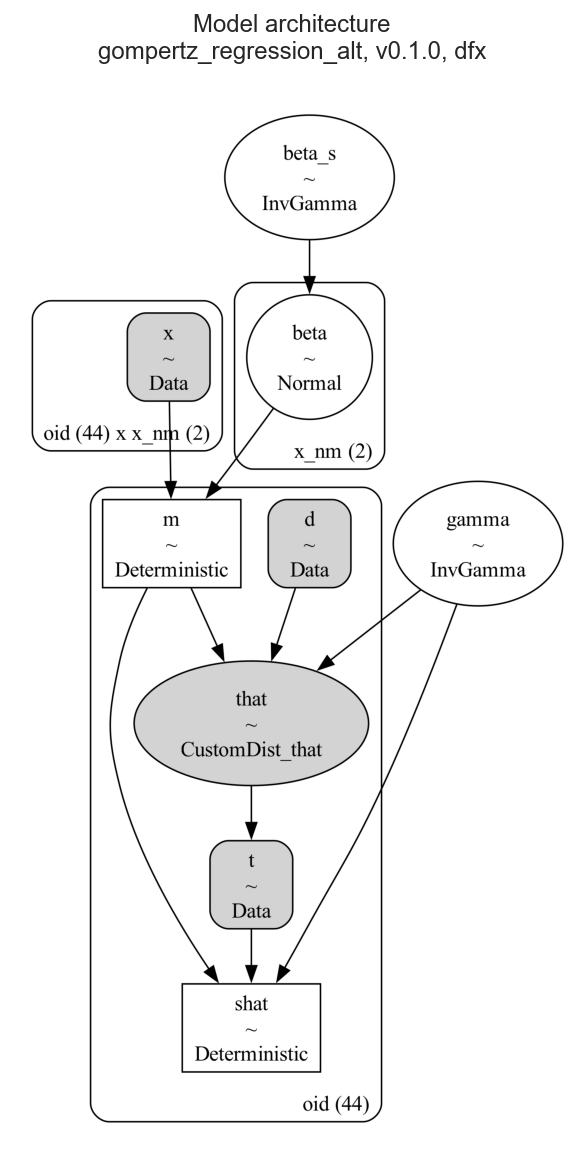

In [11]:
fqn = mdlio.write_graph(mdl_ga)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_ga.mdl_id}', figsize=(12, 8))

## 2.2 Sample Prior Predictive, View Diagnostics

In [12]:
mdl_ga.sample_prior_predictive(var_names=mdl_ga.rvs_prior + mdl_ga.rvs_ppc + mdl_ga.rvs_det, replace=True)

#### Evaluate PPC vs In-Sample Data

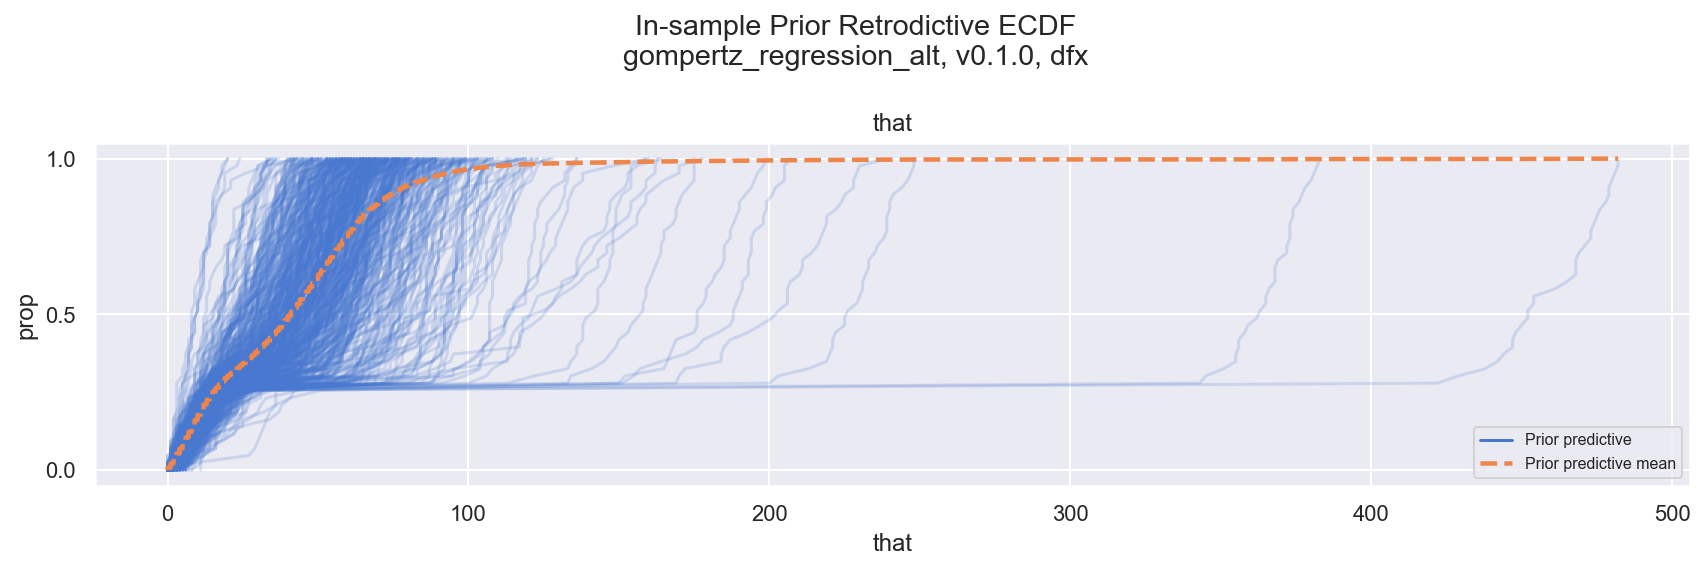

In [13]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_ga, group=GRP, var_names=['that'], insamp=True)

**Observe:**

+ Not a bad fit from the start, and range is valid 

#### Evaluate priors and hyperpriors

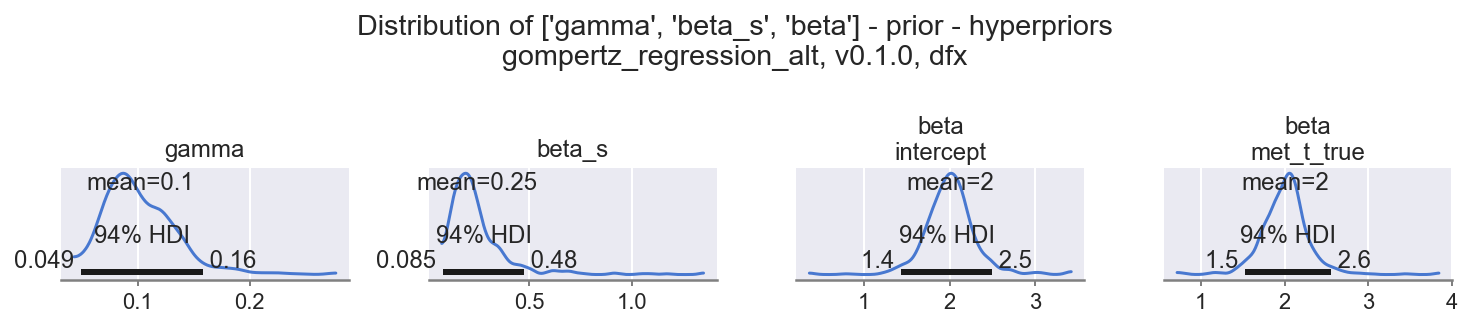

In [14]:
f = mt.facetplot_krushke(mdl=mdl_ga, group=GRP, txtadd='hyperpriors', rvs=mdl_ga.rvs_prior, m=4, rvs_hack=1)

**Observe:**

+ Reasonable $\mathbb{E}$ and HDI94 spans

Example selections of deterministic $\alpha$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


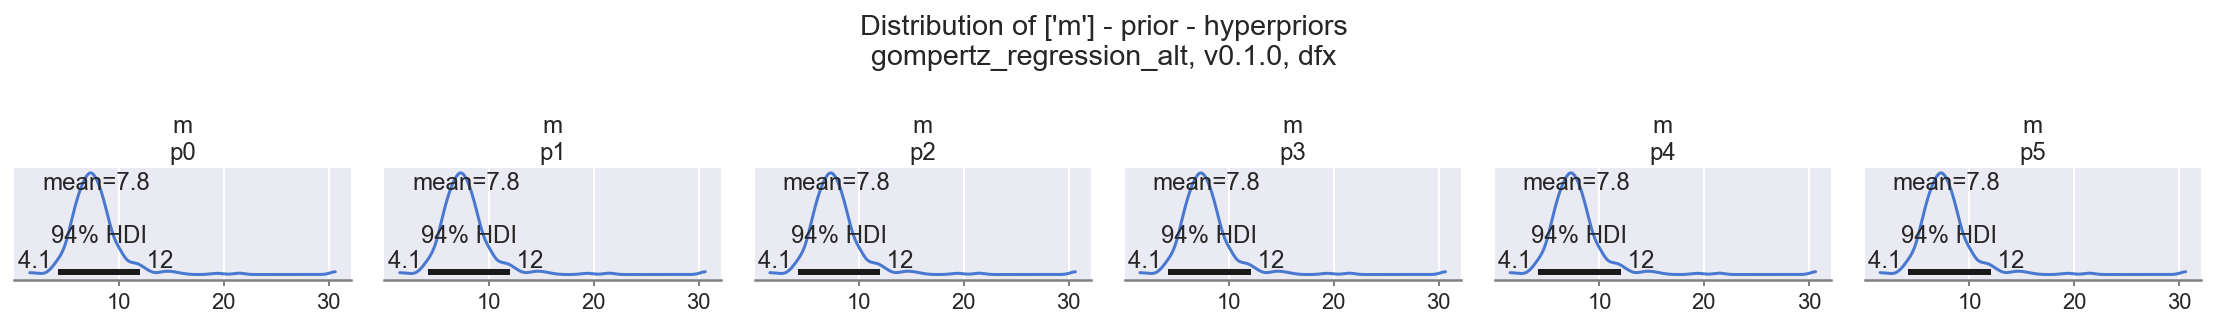

In [15]:
f = mt.facetplot_krushke(mdl=mdl_ga, group=GRP, txtadd='hyperpriors', rvs=mdl_ga.rvs_det, m=6, rvs_hack=0)

**Observe:**

+ Reasonable $\mathbb{E}$ and HDI94 spans

## 2.3 Sample Posterior, View Diagnostics

In [16]:
mdl_ga.sample(progressbar=True)
mdl_ga.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_ga.rvs_ppc)
mdlio.write_idata(mdl=mdl_ga)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_gompertz_regression_alt_v010_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.019,0.002,0.016,0.022,0.000,0.000,1616.0,1121.0,1.00
beta_s,1.818,0.571,0.873,2.838,0.015,0.011,1757.0,1183.0,1.00
beta[intercept],5.342,0.109,5.140,5.553,0.003,0.002,1063.0,1177.0,1.00
beta[met_t_true],-0.355,0.134,-0.605,-0.091,0.004,0.003,1005.0,1105.0,1.01


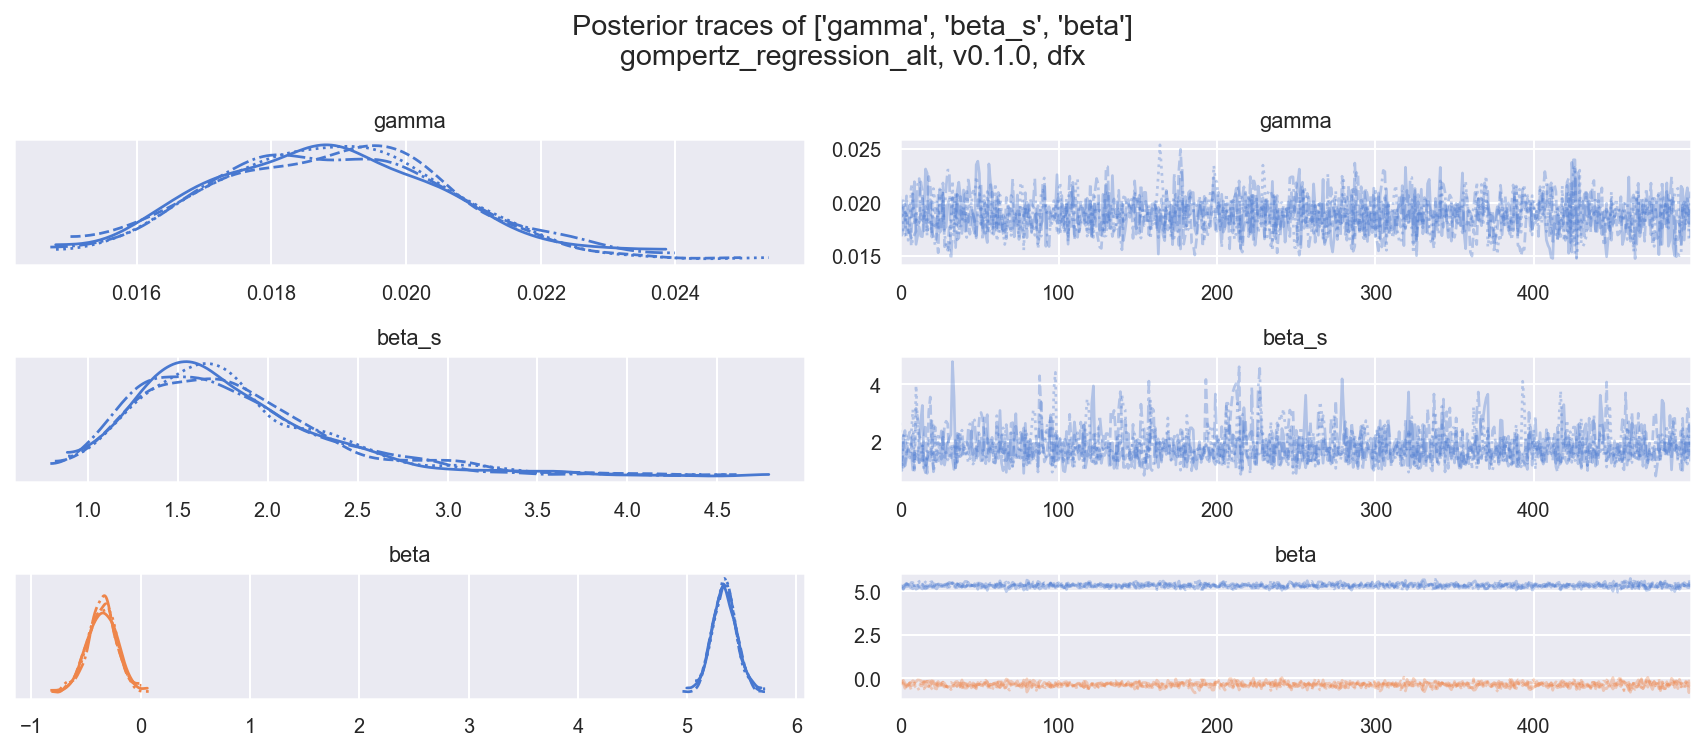

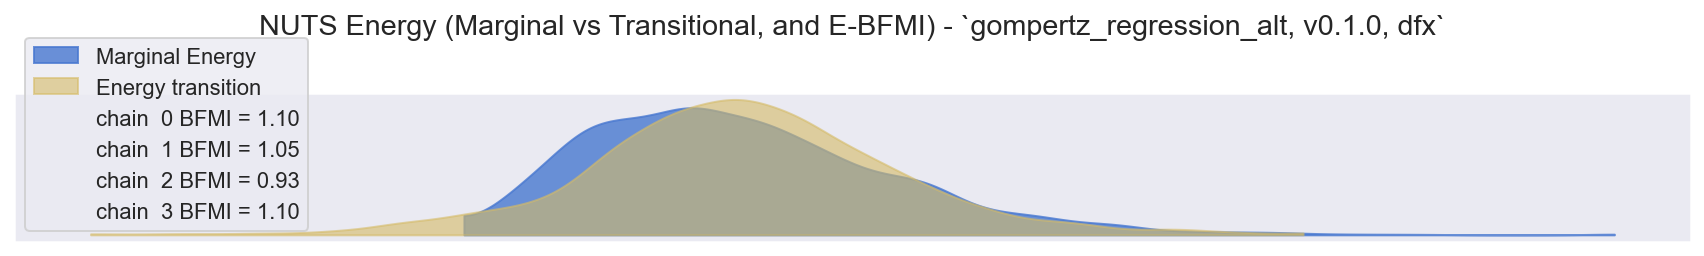

In [17]:
f = mt.plot_trace(mdl=mdl_ga, rvs=mdl_ga.rvs_prior, kind='trace')
f = mt.plot_energy(mdl=mdl_ga)
smry = mt.get_summary(mdl=mdl_ga, rvs=mdl_ga.rvs_prior)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 3.4 Evaluate Posterior PPC (In-Sample) via ECDF

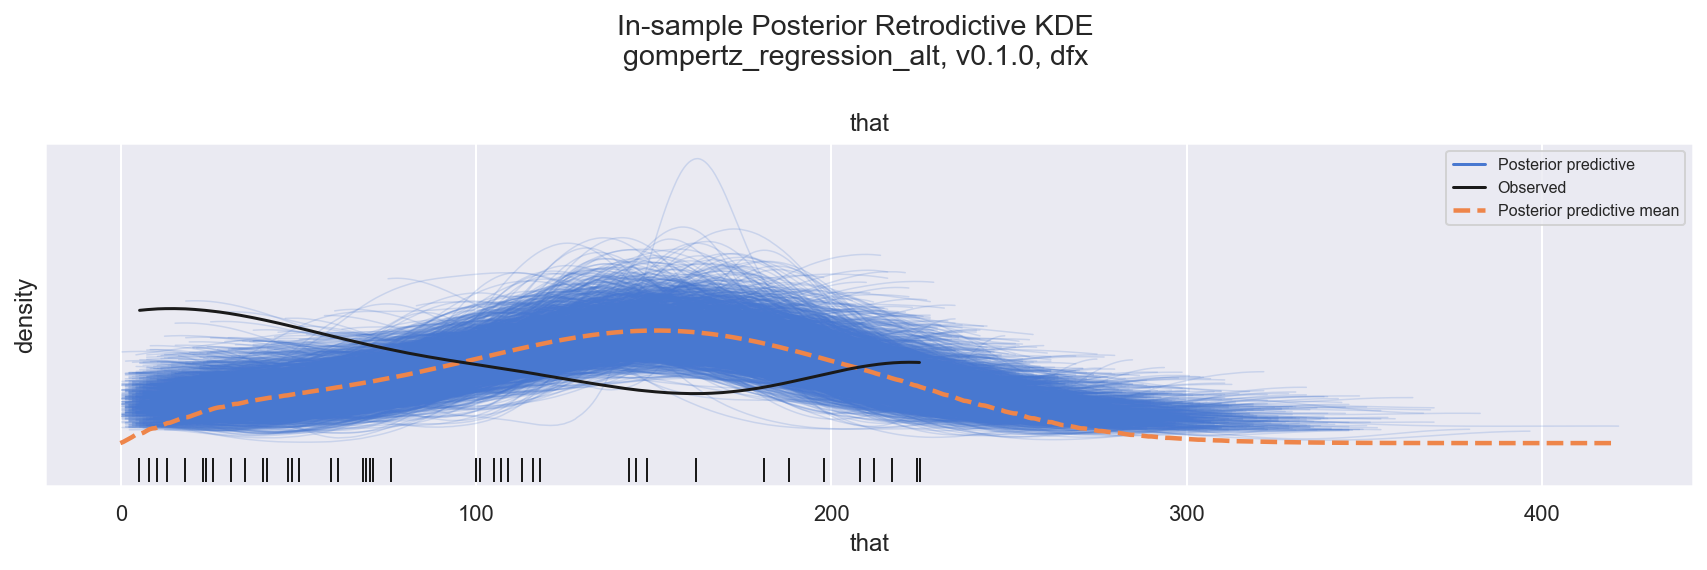

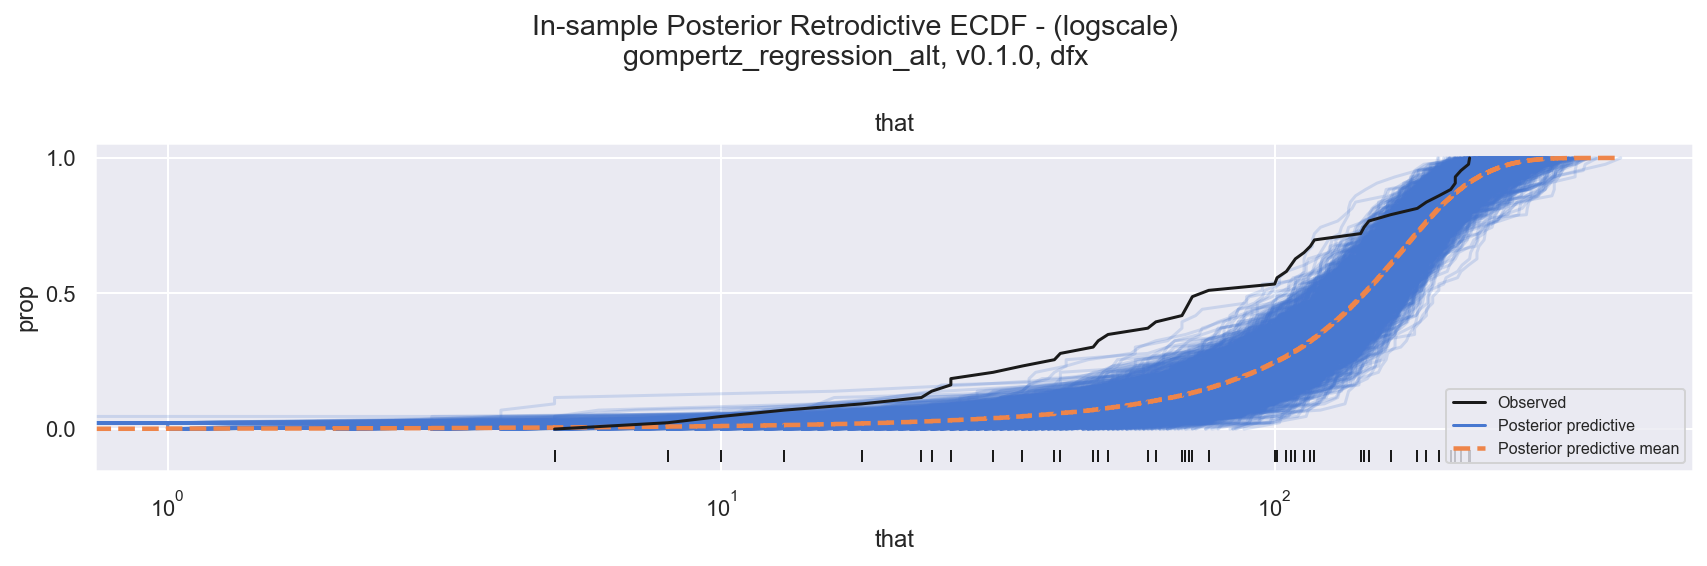

In [18]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_ga, group=GRP, var_names=['that'], ecdf=False, insamp=True)
f = mt.plot_ppc(mdl=mdl_ga, group=GRP, var_names=['that'], insamp=True, logx=True)

**Observe:**

+ Despite the better sampling, this is still a pretty poor fit, underdispersed, although it doesn't suffer the extreme 
  right-tail that the Weibull model does
+ This fit is largely as expected given that the Gompertz assumes an increasing hazard function $\lambda$, 
  and we see in our dataset that the hazard is decreasing

## 2.5 Evaluate via LOO-PIT plots (In-Sample)

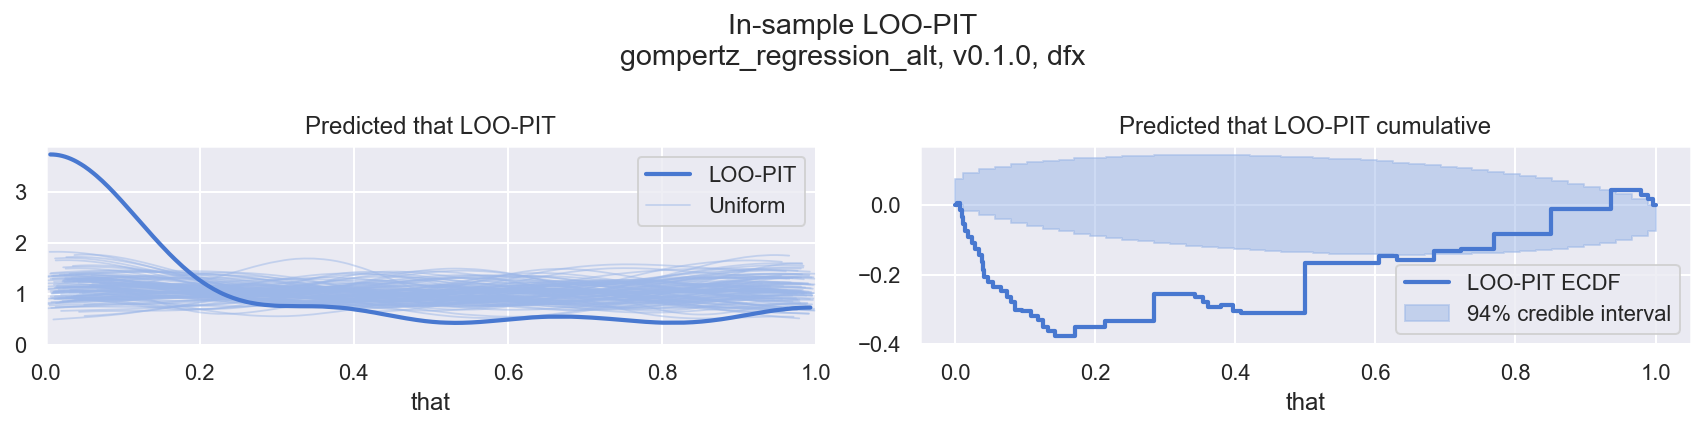

In [19]:
f = mt.plot_loo_pit(mdl_ga, data_pairs={'that': 'that'})

**Observe**

+ Pretty bad: underdispersed

## 2.6 Compare Log-Likelihood vs other models

### 2.6.1 Reinstantiate earlier models for comparison

In [20]:
mdl_eu = exponential.ExponentialUnivariate(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_eu.build()
mdl_eu_idata = mdlio.read_idata(mdl=mdl_eu)
mdl_eu.update_idata(idata=mdl_eu_idata)

In [21]:
mdl_er = exponential.ExponentialRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_er.build()
mdl_er_idata = mdlio.read_idata(mdl=mdl_er)
mdl_er.update_idata(idata=mdl_er_idata)

In [22]:
mdl_wr = aft.WeibullRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_wr.build()
mdl_wr_idata = mdlio.read_idata(mdl=mdl_wr)
mdl_wr.update_idata(idata=mdl_wr_idata)

In [23]:
mdl_gr = aft.GompertzRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_gr.build()
mdl_gr_idata = mdlio.read_idata(mdl=mdl_gr)
mdl_gr.update_idata(idata=mdl_gr_idata)

### 2.6.2 Compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl_er\nexponential_regression_v102_dfx,0,-158.680736,2.083518,0.000000,8.713491e-01,14.643382,0.000000,False,log
mdl_eu\nexponential_univariate_v102_dfx,1,-159.612908,1.179682,0.932172,1.286509e-01,14.892223,1.575394,False,log
mdl_wr\nweibull_regression_v101_dfx,2,-160.238998,2.001912,1.558263,3.330055e-15,15.218603,1.599212,False,log
mdl_ga\ngompertz_regression_alt_v010_dfx,3,-183.557344,5.719783,24.876608,7.945301e-16,16.993654,6.498535,False,log
mdl_gr\ngompertz_regression_v100_dfx,4,-184.091688,5.846561,25.410952,0.000000e+00,16.989565,6.332707,False,log


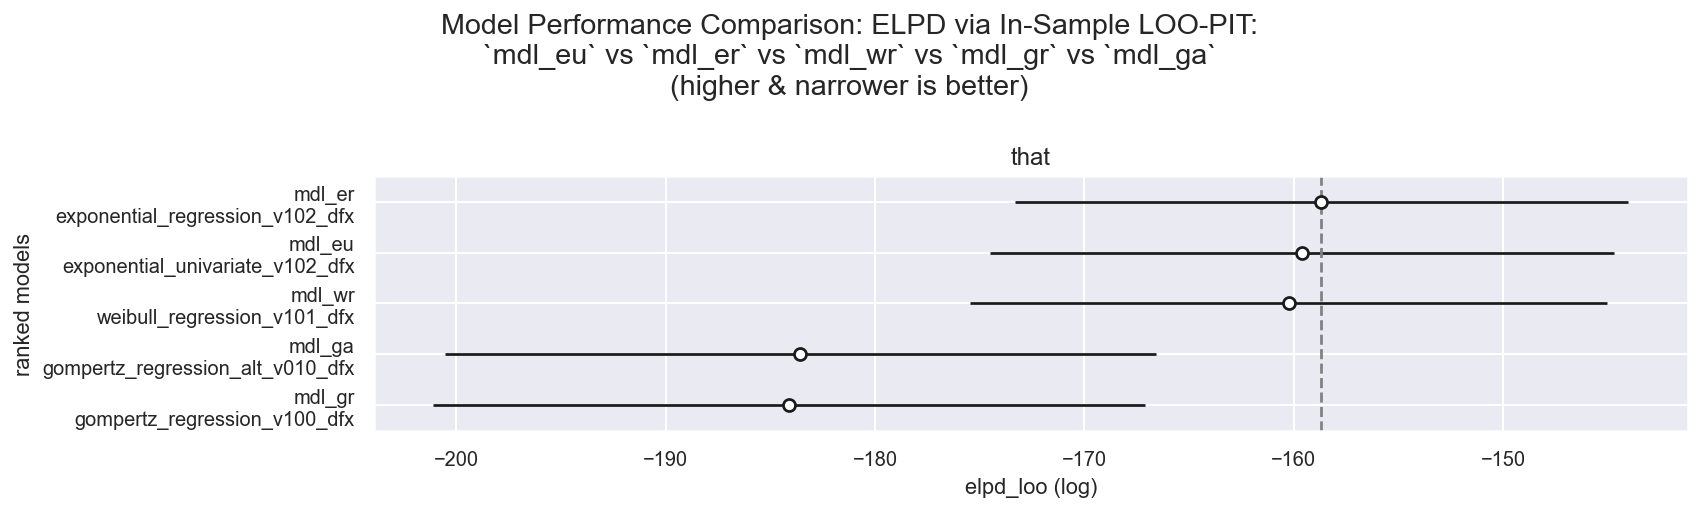

In [24]:
mdl_dict = {'mdl_eu': mdl_eu, 'mdl_er': mdl_er, 'mdl_wr': mdl_wr, 'mdl_gr': mdl_gr, 'mdl_ga': mdl_ga}
f, dcomp = mt.plot_compare(mdl_dict, yhats=['that'])
_ = [display(d) for d in dcomp.values()]

**Observe:**

+ Again we see the `Gompertz` models performing poorly: again this is not surprising because these are suitable for increasing
  hazard functions $\lambda$, whereas we have already seen for this dataset the hazard _decreases_
+ Interestingly, the reparameterised `gompertz_regression_alt` performs a little better than it's conventional sibling: this also indicates better sampling

In [25]:
del mdl_eu, mdl_er, mdl_wr, mdl_gr

## 2.7 Evaluate Posterior Parameters

### 2.7.1 Evaluate priors and hyperpriors

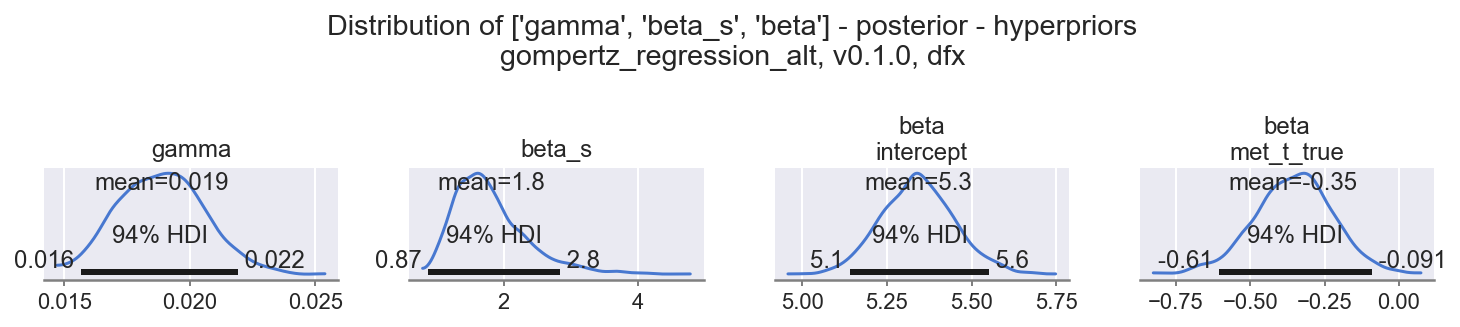

In [26]:
f = mt.facetplot_krushke(mdl=mdl_ga, group=GRP, txtadd='hyperpriors', rvs=mdl_ga.rvs_prior, m=4, rvs_hack=1)

**Observe:**

+ `gamma`: $\mathbb{E} \sim 0.019$, $\text{HDI}_{94}$ narrower than prior. Same location as `gompertz_regression`.
+ `beta_s`: $\mathbb{E} \sim 1.8$, $\text{HDI}_{94}$ quite broad. Same location as `gompertz_regression`
+ `beta: intercept`: $\mathbb{E} \sim 5.3$, $0 \notin \text{HDI}_{94}$! Baseline $M$ later mortality
+ `beta: met_t_true`: $\mathbb{E} \sim -0.35$, $0 \notin \text{HDI}_{94}$! Substantially moves $M$ to earlier mortality

Example selections of deterministic $\alpha$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


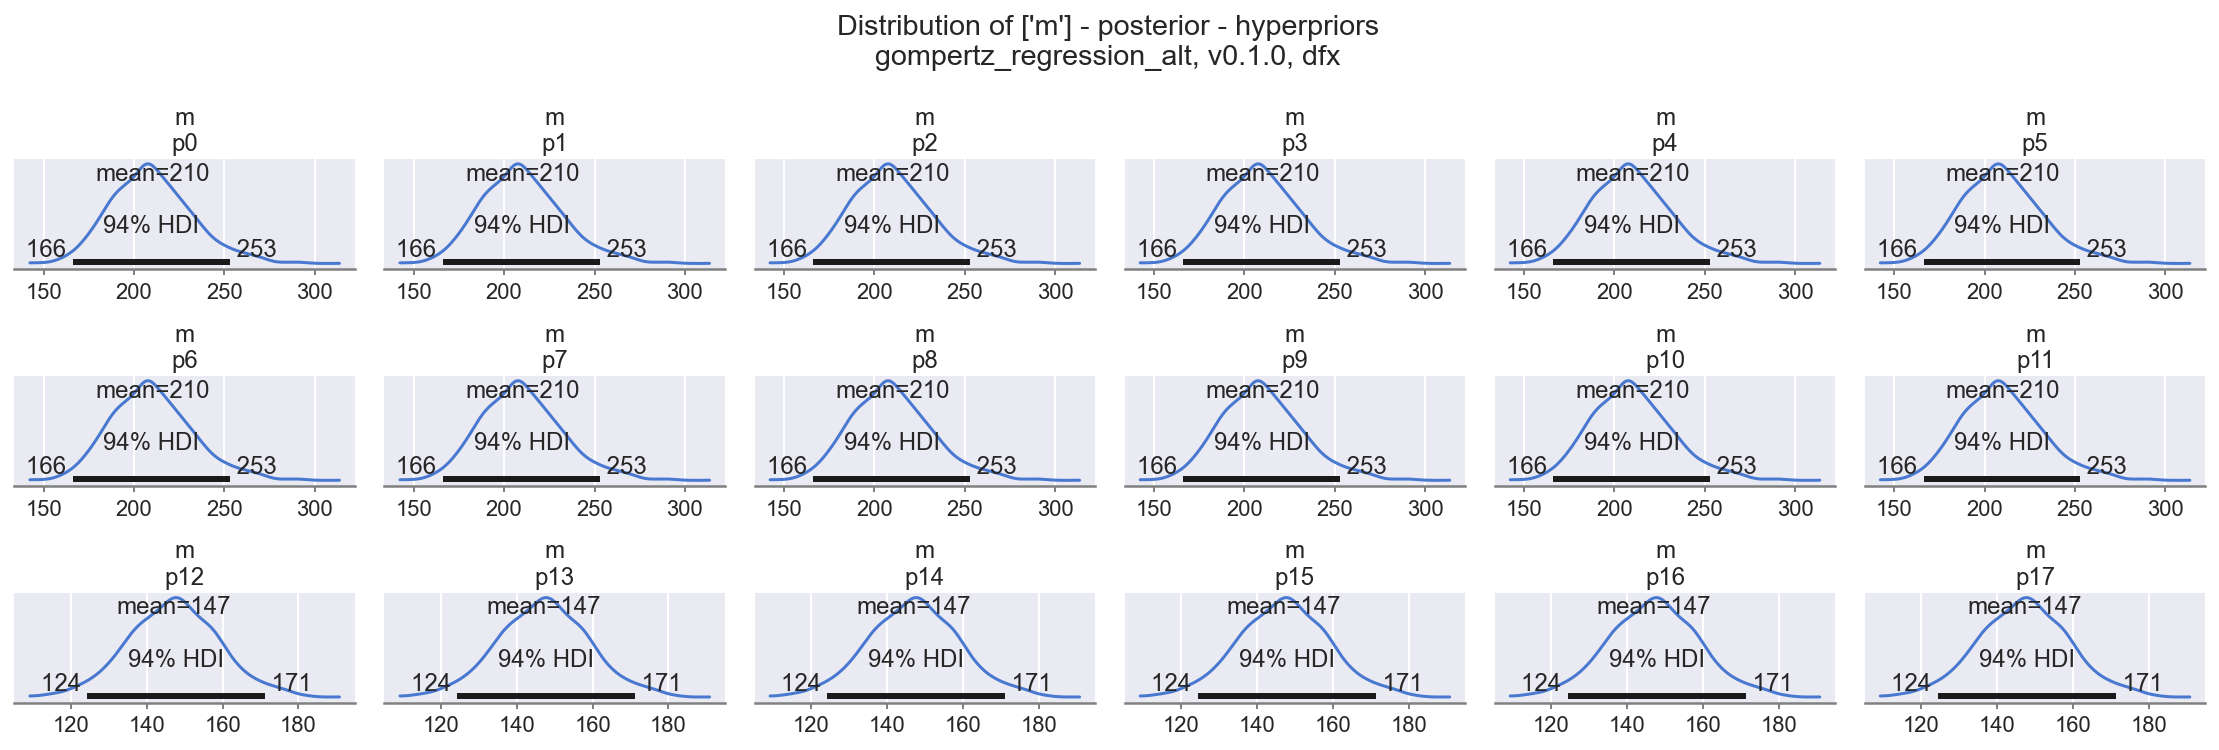

In [27]:
f = mt.facetplot_krushke(mdl=mdl_ga, group=GRP, txtadd='hyperpriors', rvs=mdl_ga.rvs_det, m=6, rvs_hack=2)

**Observe:**

+ Per the dataset and linear model formulation, there's only two groups in here, explained by `met_t_true`. The first 12 are `met_t_true=0`, and the rest (not all are shown for brevity) are `met_t_true=1`
+ As the posteriors on $\beta$ indicated, when `met_t_true=1`, $\eta > 0$, which means mortality is higher at the start of the observation period

### 2.7.1 Special look at `M` vs `gamma`

Let's see if the posterior samples of `M` and `gamma` are less correlated in this reparameterised model.Compare to the plot of the conventional parameters (`eta`, `gamma`) in `201_AFT_Gompertz.ipynb` $\S2.7$

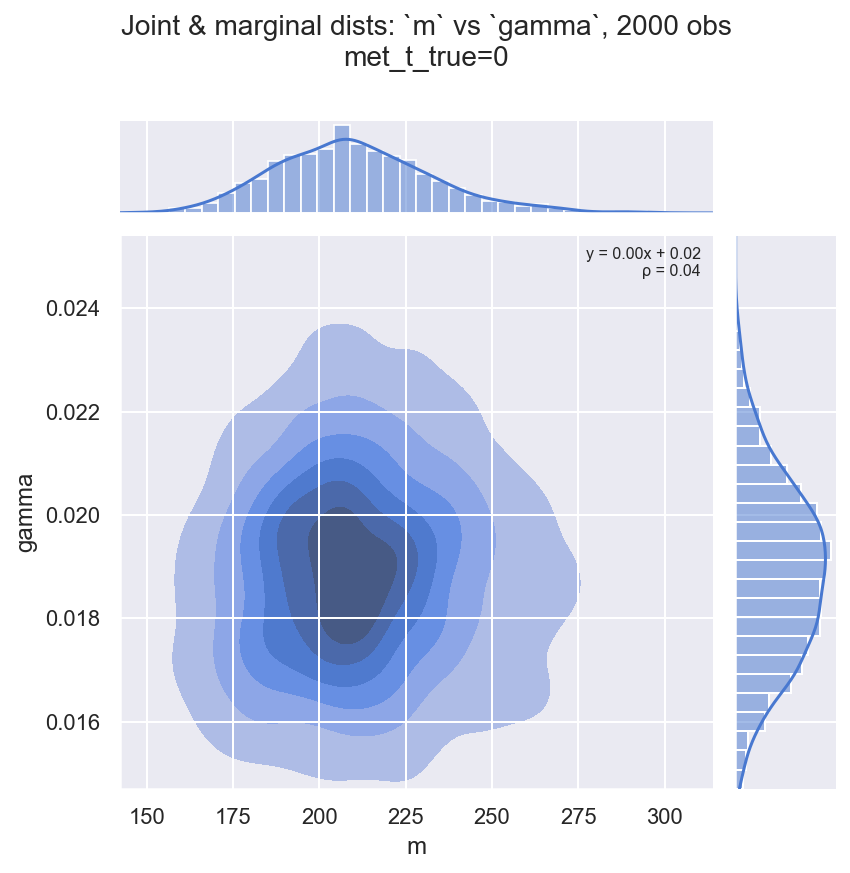

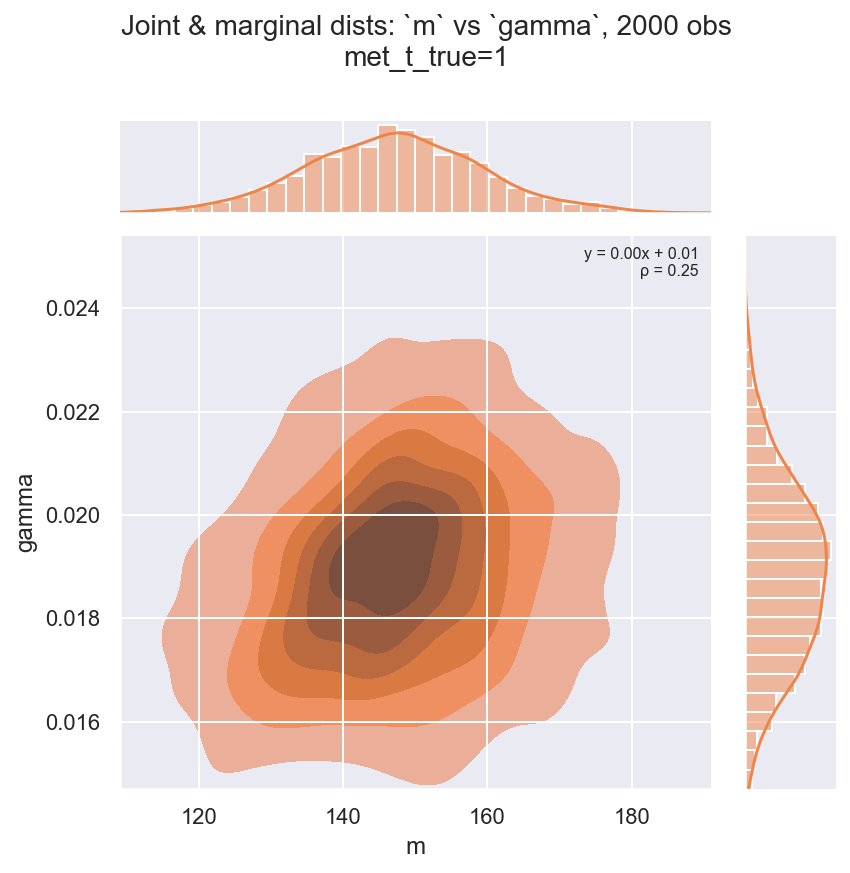

In [28]:
df_m = az.extract(mdl_ga.idata, group='posterior', var_names='m').to_dataframe()[['m']]
df_g = az.extract(mdl_ga.idata, group='posterior', var_names='gamma').to_dataframe()[['gamma']]
df_m0_g = pd.merge(df_m.loc['p0'], df_g, how='outer', left_index=True, right_index=True)
df_m1_g = pd.merge(df_m.loc['p12'], df_g, how='outer', left_index=True, right_index=True)
f = eda.plot_joint_numeric(df_m0_g, ft0='m', ft1='gamma', txtadd='met_t_true=0')
f = eda.plot_joint_numeric(df_m1_g, ft0='m', ft1='gamma', txtadd='met_t_true=1', colori=1)

**Observe:**

+ Beautiful, the posteriors for `M` and `gamma` are very uncorrelated
+ This is another reflection of the improved sampling, increased ESS and improved LOO-PIT performance vs the 
  conventenional parameterisation, and encourages / justifies our future use of the $M$ reparameterisation

## 2.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is parametric, we can **forecast** Survival $\hat{S}(t)$ and Expected Time-to-Event 
  $\hat{\mathbb{E}}_{t}$ for observations in an **out-of-sample dataset**

> See the full detailled discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 2.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [29]:
dfs = utils.get_synthetic_df_oos(df, ndur=20)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_ga.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_ga.build()
f_idata = mdl_ga.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_ga.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True)
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,chain,draw,shat,that,oid_sub,t,intercept,met_t_true,pid,met,death,duration
0,z000-0,0,0,1.00e+00,269.0,z000,0,1.0,0.0,z000-0,False,False,0
1,z000-0,0,1,1.00e+00,122.0,z000,0,1.0,0.0,z000-0,False,False,0
2,z000-0,0,2,1.00e+00,54.0,z000,0,1.0,0.0,z000-0,False,False,0
79997,z001-226,3,497,1.08e-02,147.0,z001,226,1.0,1.0,z001-226,True,False,226
79998,z001-226,3,498,4.11e-03,177.0,z001,226,1.0,1.0,z001-226,True,False,226
79999,z001-226,3,499,7.08e-03,156.0,z001,226,1.0,1.0,z001-226,True,False,226


'Shape: (80000, 13), Memsize 8.3 MB'

### 2.8.2 Plot estimated Survival $\hat{S}(t)$

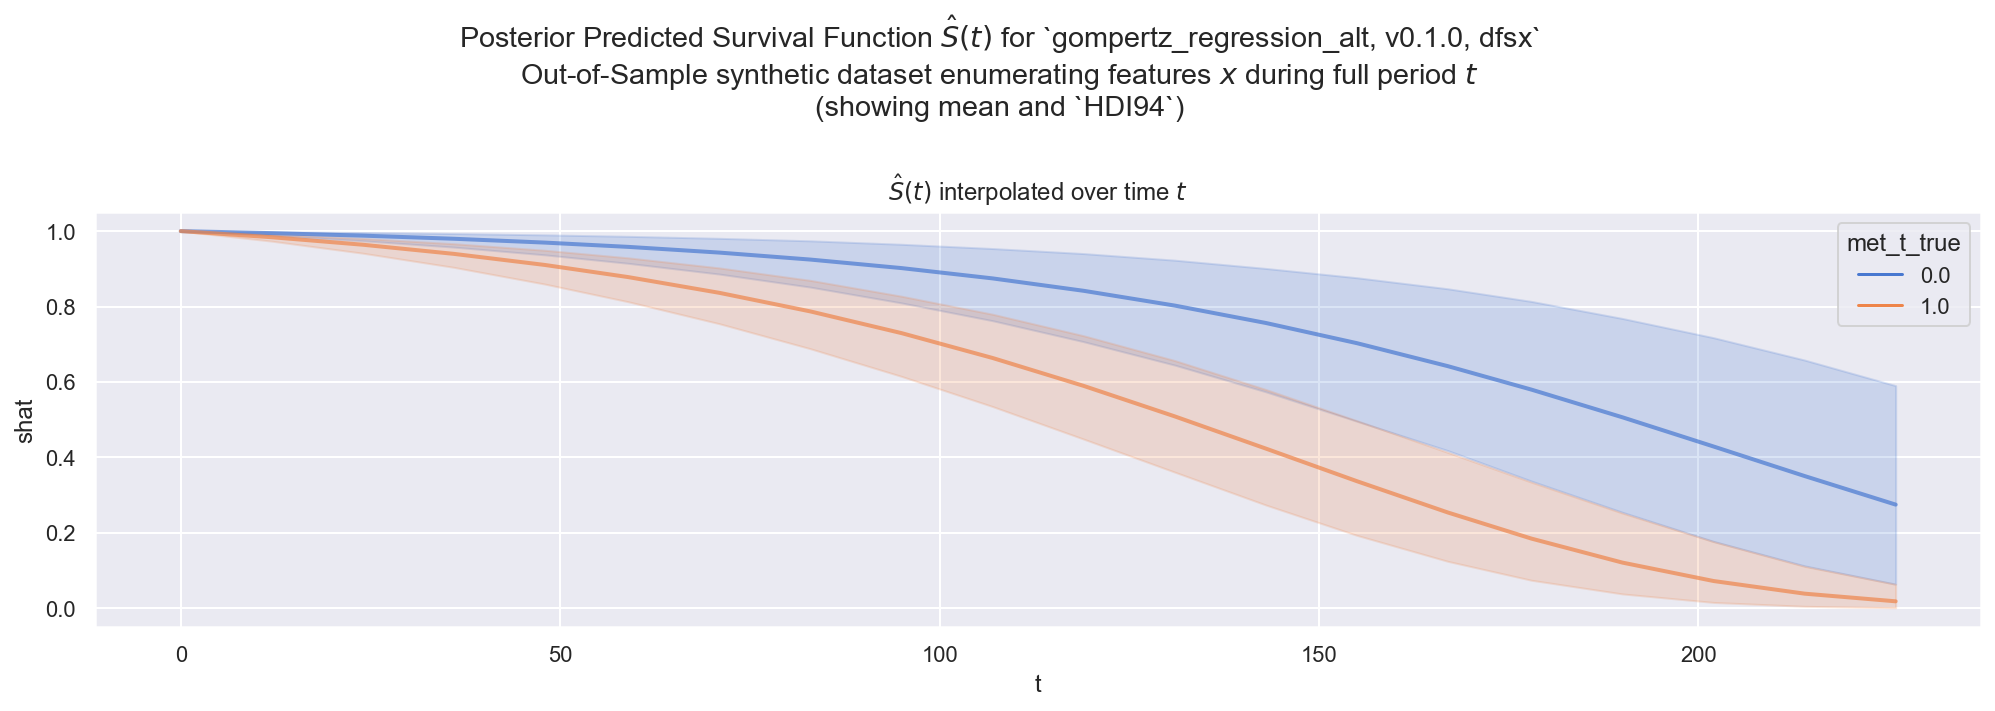

In [30]:
f, axs = plt.subplots(1, 1, figsize=(14, 5), sharex=False)
ax = sns.lineplot(x='t', y='shat',  hue='met_t_true', style='met_t_true', data=dfp, ms=10, dashes=False, 
        alpha=0.7, legend=True, lw=2, ax=axs, estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Function $\hat{{S}}(t)$ for `{mdl_ga.mdl_id}`'
            + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
            + '\n(showing mean and `HDI94`)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'202_{mdl_ga.mdl_id}_forecast_shat')

### 2.8.3 Plot estimated Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

We will only use Option A: Based on idealised parametric $\hat{\mathbb{E}}_{t} \sim S^{-1}(u) \sim 1/\gamma \cdot \log(1 - (\log(1 - u) / \exp(-\gamma M)))$

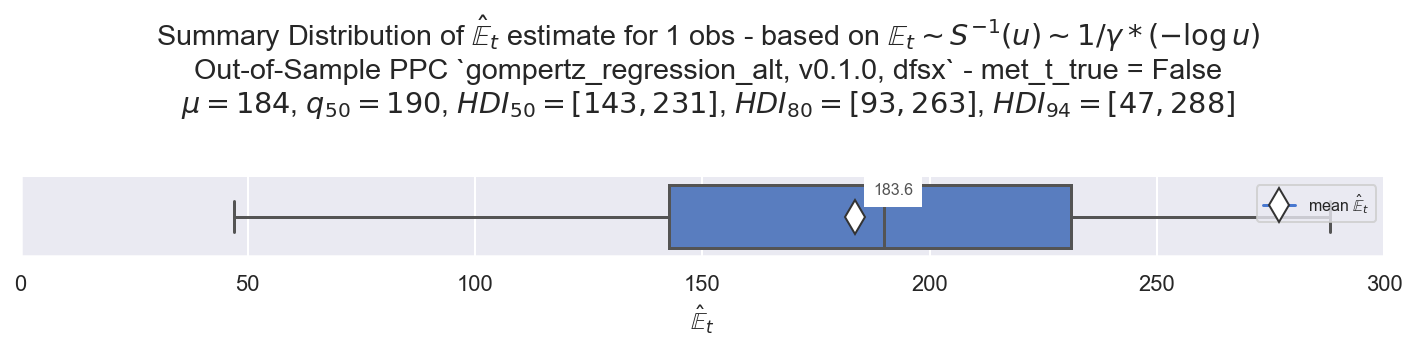

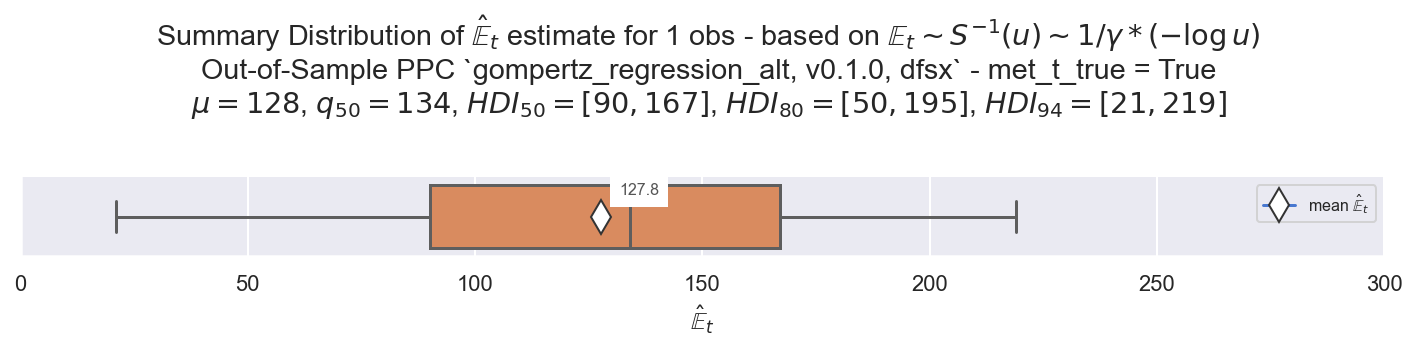

In [31]:
df_et = dfp.loc[dfp['t']==0].groupby(['pid', 'chain', 'draw', 'met_t_true'])['that'].mean().to_frame('$\hat{\mathbb{E}}_{t}$')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 0], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_ga.mdl_id}` - met_t_true = False'), force_xlim=(0, 300))
fqn = figio.write(f, fn=f'202_{mdl_ga.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 1], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_ga.mdl_id}` - met_t_true = True'), force_xlim=(0, 300), color='C1')
fqn = figio.write(f, fn=f'202_{mdl_ga.mdl_id}_forecast_et_met_true')

**Observe:**

+ The distributions of forecasted expected survival times $\hat{\mathbb{E}}_{t}$ for our **synthetic out-of-sample dataset** 
  dont look great with this model:
  + For `met = False`: $\hat{\mathbb{E}}_{t} \sim 184 \in [47, 288]_{HDI94}$ days
  + For `met = True`: $\hat{\mathbb{E}}_{t} \sim 128 \in [21, 219]_{HDI94}$ days
+ Like the sibling `GompertzRegression` model, these empirical predicted distributions are both substantially higher than 
  the other model types, although these predictions are a little closer, again reflecting the improved sampling due to 
  the reparameterisation

# Notes

In [32]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 18:00:58

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
scipy     : 1.14.1
oreum_core: 0.9.7
pandas    : 2.2.3
seaborn   : 0.12.2
pyprojroot: 0.3.0
matplotlib: 3.9.2
arviz     : 0.20.0
numpy     : 1.26.4



---
**Oreum OÜ &copy; 2024**